In [33]:
import numpy as np
import matplotlib.pyplot as plt
from lgca import get_lgca
from scipy.integrate import  solve_ivp
from scipy.special import erf
from math import sqrt
from scipy.ndimage import laplace, convolve1d
import seaborn as sns
from scipy.stats import gamma, expon, truncexpon
import pickle as pkl
#from scipy import integrate
from tqdm.auto import tqdm

In [199]:
# figwidth = 6.224
# golden_ratio = 1.61803
# figsize = (figwidth, figwidth / golden_ratio)
import matplotlib as mpl
plt.style.use('default')
# plt.style.use('thesis_style.mplstyle') # only activate for thesis, adjust height
# sns.set_style("ticks")
# sns.set_palette('colorblind')
# mpl.rcParams['figure.figsize'] = figsize
# mpl.rcParams['lines.linewidth'] = 2
# mpl.rcParams['font.size'] = 8
# plt.rcParams['svg.fonttype'] = 'path'

In [8]:
import string
from itertools import cycle
def label_axes(fig, labels=None, loc=None, **kwargs):
    """
    Walks through axes and labels each.
    kwargs are collected and passed to `annotate`
    Parameters
    ----------
    fig : Figure
         Figure object to work on
    labels : iterable or None
        iterable of strings to use to label the axes.
        If None, lower case letters are used.
    loc : len=2 tuple of floats
        Where to put the label in axes-fraction units
    """
    if labels is None:
        labels = string.ascii_lowercase

    # re-use labels rather than stop labeling
    labels = cycle(labels)
    if loc is None:
        loc = (0., 1.1)
    for ax, lab in zip(fig.axes, labels):
        ax.annotate(lab, xy=loc, ha='right', weight='bold', xycoords='axes fraction', usetex=False, fontsize=11, **kwargs)

In [9]:
def gaussian(x):
    y = np.exp(-0.5 * x ** 2) / sqrt(2 * np.pi)
    return y


def cdf_gaussian(x):
    y = 0.5 * (1 + erf(x / sqrt(2)))
    return y

def exp(x, rate):
    # exponential pdf where x >= 0 else 0
    pdf = np.zeros_like(x)
    pdf[np.where(x >= 0)] = np.exp(-x[np.where(x >= 0)] * rate) * rate
    return pdf

def cdf_exp(x, rate):
    return 1 - np.exp(-x * rate)

def trunc_exp(x, rate, xmax):
    y = exp(x, rate)
    y /= cdf_exp(xmax, rate)
    return y

def trunc_gaussian(x, mu, sigma, a=0, b=1):
    """
    Truncated Gaussian distribution with mean mu and standard deviation sigma truncated to the interval [a,b]
    Parameters
    ----------
    x : array
    mu : float
    sigma : float
    a : float
    b : float

    Returns
    -------

    """
    xi = (x - mu) / sigma
    beta = (b - mu) / sigma
    alpha = (a - mu) / sigma
    y = gaussian(xi) / sigma
    y /= cdf_gaussian(beta) - cdf_gaussian(alpha)
    return y

def gamma_kernel(x, shape, loc, scale_pos, scale_neg, p_pos):
    dx = x[1] - x[0]
    y1 = gamma.pdf(-x, shape, -loc, scale_neg)
    y2 = gamma.pdf(x, shape, loc, scale_pos)
    y = y1 * (1-p_pos) + y2 * p_pos
    y[y == np.inf] = 0
    y /= np.trapz(y, x, dx)
    return y

def exponential_kernel(x, loc, scale1, scale2, p_pos, a_min, a_max):  # scale is equal to 1 / lambda = mean
    dx = x[1] - x[0]
    # y1 = expon.pdf(-x, -a_min, loc=-loc, scale=scale1)
    # y2 = expon.pdf(x, a_max, loc=loc, scale=scale2)
    y1 = expon.pdf(-x, loc=-loc, scale=scale1)
    y2 = expon.pdf(x, loc=loc, scale=scale2)
    # y1 /= np.trapz(y1, dx=dx)
    # y2 /= np.trapz(y2, dx=dx)
    # y1 /= 1 - np.exp((a_min - loc)/ scale1)
    # y2 /= 1 - np.exp((loc - a_max)/ scale2)
    # y = np.empty_like(x)
    # y[np.where(x <= 0)] = y1[np.where(x <= 0)][::-1] * (1-p_pos)
    # y[np.where(x >= 0)] = y2[np.where(x >= 0)] * p_pos
    y = y1 * (1-p_pos) + y2 * p_pos
    # y /= np.trapz(y, x, dx)
    return y

def dydt_int(t, y, alpha, r_d, p, kernel):
    dalpha = alpha[1] - alpha[0]
    #     rho = y.sum() * dalpha
    rho = np.trapz(y, dx=dalpha)
    # dy = np.empty_like(y)
    alpharho = alpha * y
    # for i, a in enumerate(alpha):
    #     dy[i] = np.trapz(alpha * y * kernel[i], dx=dalpha)
        
    dy = (1-p) * alpharho + p * np.trapz(alpharho * np.flip(kernel), dx=dalpha, axis=-1)

    #     dy = alpha * y + var * np.gradient(y, dalpha) + 0.5 * alpha * var * laplace(y) / dalpha**2
    dy *= 1 - rho
    dy -= r_d * y
    dy[0] = 0
    dy[-1] = 0  # neumann bcs
    return dy

def dydt_int_co(t, y, alpha, r_d, p, kernel, K):
    dalpha = alpha[1] - alpha[0]
    #     rho = y.sum() * dalpha
    rho = np.trapz(y, dx=dalpha)
    # dy = np.empty_like(y)
    alpharho = np.heaviside(y - 1/K, .5) * alpha * y
    # for i, a in enumerate(alpha):
    #     dy[i] = np.trapz(alpha * y * kernel[i], dx=dalpha)
        
    dy = (1-p) * alpharho + p * np.trapz(alpharho * np.flip(kernel), dx=dalpha, axis=-1)
    # dy = (1-p) * alpharho + p * np.sum(alpharho * kernel, axis=-1) * dalpha
    #     dy = alpha * y + var * np.gradient(y, dalpha) + 0.5 * alpha * var * laplace(y) / dalpha**2
    dy *= 1 - rho
    dy -= r_d * y
    dy[0] = 0
    dy[-1] = 0  # neumann bcs
    return dy

# first order approximation
def dydt(t, y, alpha, r_d, p, mean, secondmoment):
    da = alpha[1] - alpha[0]
    rho = np.trapz(y, dx=da)
    alpharho = alpha * y
    dy = alpharho + p * (-mean * np.gradient(alpharho, da) + secondmoment / 2 * laplace(alpharho) / da**2)
    # dy = alpharho + v * (2 * np.gradient(y, da) + alpha * laplace(y) / da**2)
    # yL1 = y[-2] - y[-1] / alpha[-1] * 2 * da  # v = var / da**2 / 2
    # dy[-1] = alpharho[-1] - v / da**2 * (da * (yL1 - y[-2]) + alpha[-1] * (y[-2] - 2 * y[-1] + yL1))  # zero flux boundary condition (Robin)
    dy *= 1 - rho
    dy -= r_d * y
    dy[0] = 0 # Dirichlet, Robin and Neumann boundary amounts to the same at the left boundary
    dy[-1] = 0  # neumann condition
    return dy

def dydt_co(t, y, alpha, r_d, p, mean, secondmoment, K):
    da = alpha[1] - alpha[0]
    rho = np.trapz(y, dx=da)
    alpharho = alpha * y
    dy = np.heaviside(y - 1/K, .5) * alpharho + p * (-mean * np.gradient(alpharho, da, axis=0) + secondmoment / 2 * convolve1d(alpharho, [1., -2., 1.], axis=0) / da**2)
    # dy = alpharho + v * (2 * np.gradient(y, da) + alpha * laplace(y) / da**2)
    # yL1 = y[-2] - y[-1] / alpha[-1] * 2 * da  # v = var / da**2 / 2
    # dy[-1] = alpharho[-1] - v / da**2 * (da * (yL1 - y[-2]) + alpha[-1] * (y[-2] - 2 * y[-1] + yL1))  # zero flux boundary condition (Robin)
    dy *= 1 - rho
    dy -= r_d * y
    dy[0] = 0 # Dirichlet, Robin and Neumann boundary amounts to the same at the left boundary
    dy[-1] = 0  # neumann condition
    return dy

# analytical predictions for bulk
def meanfitness(t, r_b, r_d, m, v0):
    """
    mean fitness over time in the bulk, given initial mean birth rate r_b, initial variance v0, mutationrate m
    """
    return np.sqrt(r_d**2 * m * t**2 + 2 * r_d * (v0+m) * t + r_b**2)


In [200]:
a_max = 1.
a_min = 0.
na = 401
alpha, dalpha = np.linspace(a_min, a_max, num=na, retstep=True)
r_d = 0.25
r_b = 0.5
# p_mut = 1
p_l = 1e-8
T_d = 700
# T_d = 1400
T_p = 5e6
# T_p = 1e7
p_d = T_d * p_l
p_p = T_p * p_l
p_mut = 1 - (1 - p_d) * (1 - p_p)
p_pos = T_d / (T_d + T_p)
s_p = 0.001 * r_b
s_d = 0.2 * r_b
# s_p = 0.001
# s_d = 0.1
# p_pos = 0
# var = 0.0001
# mean and variance for double exponential distribution (without truncation)
mean_mut_effect = p_pos * s_d - (1 - p_pos) * s_p
var = p_pos * s_d**2 + (1 - p_pos) * s_p**2
# gamma distribution like in basener et al 2018
# var = 0.1**2
# mean = shape * scale = .5 * scale
# shape = .5
# scale_d = 2 * s_d
# scale_p = 2 * s_p
# var = p_pos * shape * scale_d**2 + (1 - p_pos) * shape * scale_p**2
# # scale = (.5 - p_mut * shape) / mean
# scale = np.sqrt(.025)
# p_pos = .5 * (-.05/scale + 1)
# mean_mut_effect = -shape*scale * (1-p_pos) + p_pos * shape*scale
# var = shape*scale**2

mu = np.linspace(-(a_max-a_min), a_max-a_min, 2 * na - 1)
# basekernel = gamma_kernel(mu, shape, 0, scale_d, scale_p, p_pos)
# # basekernel[len(basekernel)//2] = 0
# kernel = np.array([gamma_kernel(alpha, shape, a, scale_d, scale_p,  p_pos) for a in alpha])
tmax = 40000
# Da = var / 2
dens0 = 1 - r_d / r_b
ts = np.linspace(0, tmax, num=101)
dmu = mu[1] - mu[0]
# print((mu[1] - mu[0]), dalpha)
# basekernel = trunc_gaussian(mu, 0., sqrt(var), a=-(a_max-a_min), b=a_max-a_min)
basekernel = exponential_kernel(mu, 0., s_p, s_d, p_pos, mu[0], mu[-1])
# kernel = np.array([trunc_gaussian(a - alpha, 0., sqrt(var), a=a_min - alpha, b=a_max - alpha) for a in alpha])
kernel = np.array([exponential_kernel(a - alpha, 0., s_p, s_d, p_pos, a_min - alpha, a_max - alpha) for a in alpha])
# K = 500
Ncrit = T_p * (s_p / r_b) / T_d / (s_d/r_b)**2
mucrit = s_d / T_p / r_b
K = np.ceil(Ncrit * 4)  # check mcfarland theory
y0 = np.zeros_like(alpha)
# y0[np.argwhere(alpha==r_b)] = dens0 / dalpha
# set y0 to dens0/dalapha at the point where alpha near r_b
y0[np.argmin(np.abs(alpha - r_b))] = dens0 / dalpha

In [133]:
print(dalpha, s_p, s_d, p_pos, p_mut, Ncrit / K, dens0, Ncrit, K, mucrit, p_l)

0.0025 0.0005 0.1 0.00013998040274361588 0.05000665000000004 0.24975024975024973 0.5 178.57142857142856 715.0 4e-08 1e-08


In [134]:
np.trapz(basekernel, dx=dmu)

5.0333553557168855

(1e-06, 10000.0)

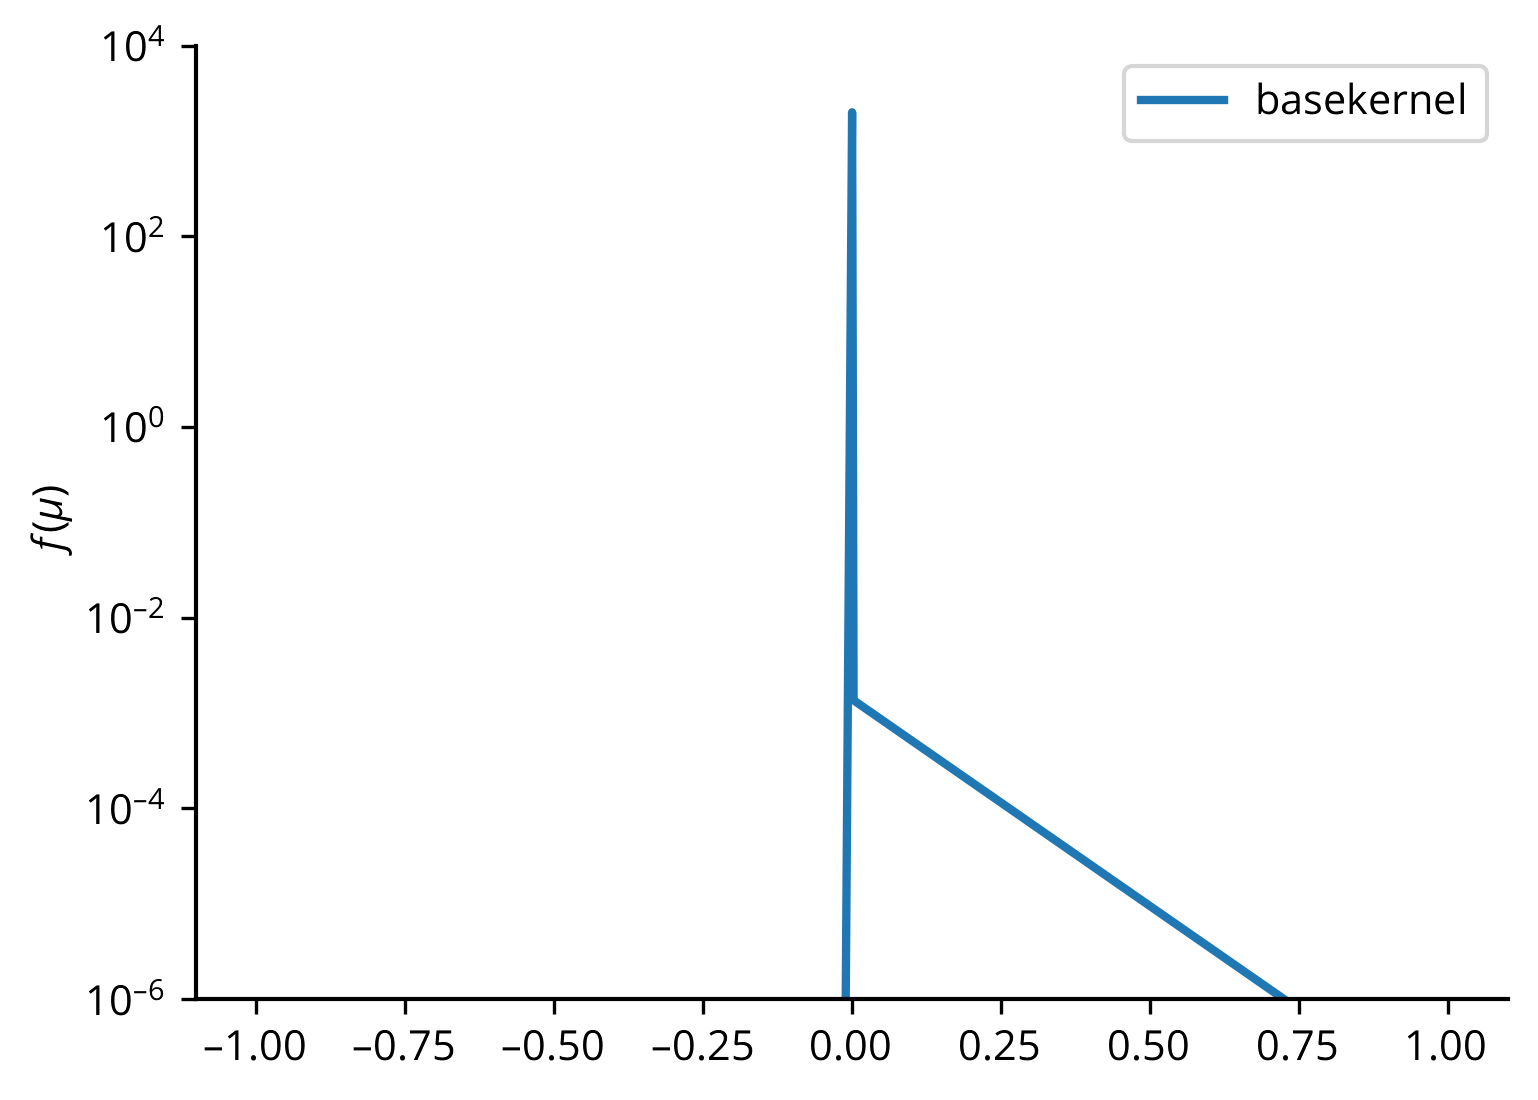

In [135]:
plt.plot(mu, basekernel, label='basekernel')
# plt.xlabel(r'\textrm{Mutation 0.25} Mutation 0.25 n$\mu$')
plt.ylabel(r'$f(\mu)$')
plt.legend()
plt.yscale('log')
plt.ylim(1e-6, 1e4)
# plt.xlim(-0.02, .02)

In [137]:
meanmu = np.trapz(mu * basekernel, dx=dalpha)
secondmommu = np.trapz(mu**2 * basekernel, dx=dalpha)

In [138]:
print(meanmu, mean_mut_effect, secondmommu, var + mean_mut_effect**2)

-7.136864042374737e-05 -0.0004859319695242666 3.0081471935034747e-06 1.8858989113412058e-06


In [139]:
secondmommu = var + mean_mut_effect**2

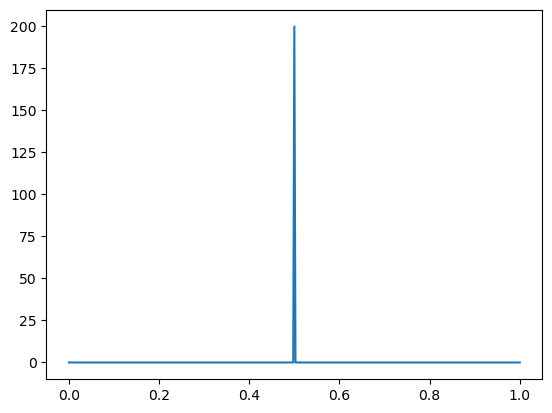

In [140]:
# plot y0
plt.plot(alpha, y0)

In [13]:
# dist = kernel[len(alpha)//2]
# means = np.array([np.trapz((alpha-alphai) * dist, dx=dalpha) for alphai in alpha])
# variances = np.array([np.trapz((alpha-alphai)**2 * dist, dx=dalpha) for alphai in alpha]) - means**2
# # print(-shape*scale, shape*scale**2, means[len(alpha)//2], variances[len(alpha)//2])
#
# plt.plot(alpha, kernel[100])
# plt.vlines(alpha[100], ymin=0, ymax=100, color='r')

In [14]:
# plt.plot(alpha, np.trapz(alpha * y0 * np.flip(kernel), dx=dalpha, axis=-1))
# plt.plot(alpha, y0, alpha=.1)

In [141]:
method = 'RK45'
# method = 'RK45'

In [142]:
sol = solve_ivp(dydt_int_co, (0, tmax), y0, t_eval=ts, args=(alpha, r_d, p_mut, kernel, K), method=method, max_step=1.).y.T
sol2 = solve_ivp(dydt_co, (0, tmax), y0, t_eval=ts, args=(alpha, r_d, p_mut, meanmu, secondmommu, K), method='DOP853')

print(sol2.message)
sol2 = sol2.y.T

The solver successfully reached the end of the integration interval.


In [17]:
# sol3 = solve_ivp(dydt_int, (0, tmax), y0, t_eval=ts, args=(alpha, r_d, p_mut, kernel), method=method, max_step=1.).y.T
# sol4 = solve_ivp(dydt, (0, tmax), y0, t_eval=ts, args=(alpha, r_d, p_mut, mean_mut_effect, secondmommu,), method=method, max_step=1.)
# print(sol4.message)
# sol4 = sol4.y.T

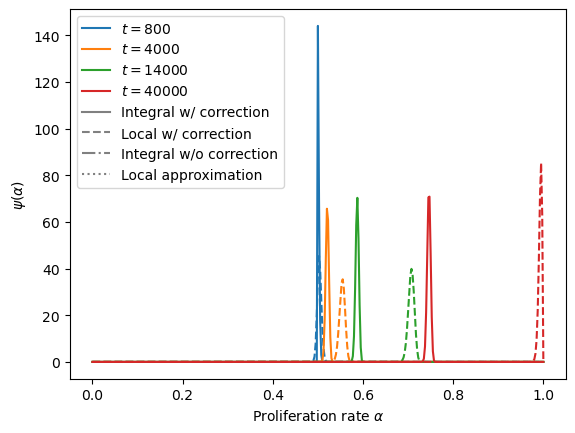

In [143]:
for t in [2, 10, 35, 100]:
    p = plt.plot(alpha, sol[t], '-', label='$t = {:n}$'.format(ts[t]))
    plt.plot(alpha, sol2[t], '--', label='_t = {:n}'.format(ts[t]), color=p[0].get_color())
    # plt.plot(alpha, sol3[t], '-.', label='_t = {:n}'.format(ts[t]), color=p[0].get_color())
    # plt.plot(alpha, sol4[t], ':', label='_t = {:n}'.format(ts[t]), color=p[0].get_color())


#plt.plot(alpha, sol[-1], label='t = {:n}'.format(ts[-1]))
# p = plt.plot(alpha, sol[t], label='t = {:n}'.format(ts[t]))
# plt.plot(alpha, sol2[0], '--', label='_t = {:n}'.format(ts[t]), color=p[0].get_color())
plt.xlabel('Proliferation rate $\\alpha$')
plt.ylabel('$\\psi(\\alpha)$')
leg = plt.legend()
lines, labels = plt.gca().get_legend_handles_labels()

# add new lines and labels
lines += [plt.Line2D([0], [0], ls=ls, c='gray') for ls in ['-', '--', '-.', ':']]
# labels += ['Local w/ correction', 'Local w/o correction']
labels += ['Integral w/ correction', 'Local w/ correction', 'Integral w/o correction', 'Local approximation']

# create a new legend with all lines and labels
plt.legend(lines, labels)
# plt.yscale('log')
# plt.ylim(0)

In [ ]:
# # lgca = get_lgca(ib=True, density=dens0, bc='reflect', interaction='birthdeath', std=sqrt(var),
#                 r_d=r_d, r_b=r_b, a_max=a_max, geometry='1d', dims=1, restchannels=K-2)
l = 6
dims= l, l
lgca = get_lgca(ib=True, density=dens0*K/7, bc='pbc', interaction='birthdeath_cancerdfe', std=sqrt(var), ve=False, capacity=K,
                r_d=r_d, r_b=r_b, a_max=a_max, geometry='hx', dims=dims, restchannels=1, s_d=s_d, p_d=p_d, p_p=p_p, s_p=s_p)
# set lgca.propagation to function that does nothing to isolate nodes
# lgca.propagation = lambda : None  # turned off propagation so that each node is isolated
lgca.timeevo(timesteps=tmax, record=True)

Rest channel weight set to gamma = 0.0


  0%|          | 0/40000 [00:00<?, ?it/s]

In [54]:
# load lgca with pickle
# with open('lgca_cancerdfe_4_isolated_20Ncrit.pickle', 'rb') as f:
#     lgca = pkl.load(f)

EOFError: Ran out of input

In [58]:
# delete lgca.propagation as it cannot be pickled
# del lgca.propagation

In [59]:
# save lgca with pickle
# with open('lgca_cancerdfe_4_isolated_20Ncrit.pickle', 'wb') as f:
#     pkl.dump(lgca, f)

In [201]:
# calc observables
rhoint_co = np.trapz(sol, dx=dalpha)
rholoc_co = np.trapz(sol2, dx=dalpha)
# rhoint = np.trapz(sol3, dx=dalpha)
# rholoc = np.trapz(sol4, dx=dalpha)
meanalphaint_co = np.trapz(sol * alpha, dx=dalpha) / rhoint_co
meanalphaloc_co = np.trapz(sol2 * alpha, dx=dalpha) / rholoc_co
# meanalphaint = np.trapz(sol3 * alpha, dx=dalpha) / rhoint
# meanalphaloc = np.trapz(sol4 * alpha, dx=dalpha) / rholoc
meanalphaana = meanfitness(ts, r_b, r_d, var, 0)
rhoana = 1 - r_d / meanalphaana

In [202]:
var_ana = r_d * var * ts
varint_co = np.trapz(sol * alpha**2, dx=dalpha) / rhoint_co - meanalphaint_co**2
varloc_co = np.trapz(sol2 * alpha**2, dx=dalpha) / rholoc_co - meanalphaloc_co**2
# varint = np.trapz(sol3 * alpha**2, dx=dalpha) / rhoint - meanalphaint**2
# varloc = np.trapz(sol4 * alpha**2, dx=dalpha) / rholoc - meanalphaloc**2

In [ ]:
prop = np.array(lgca.props['r_b'])
cells_t = lgca.nodes_t.sum((1, 2, 3))

In [ ]:
prop_t = [prop[cells] if len(cells) > 0 else np.array([np.nan]) for cells in tqdm(cells_t)]
mean_prop_t = np.array([np.mean(prop) if len(prop) > 0 else np.nan for prop in prop_t])
std_mean_prop_t = np.array([np.std(prop, ddof=1) / np.sqrt(len(prop)) if len(prop) > 0 else np.nan for prop in prop_t])

In [ ]:
var_prop_t = np.array([np.var(prop, ddof=1) if len(prop) > 0 else np.nan for prop in prop_t])

In [ ]:
plt.plot(ts, rhoint_co, label='Integral corrected')
plt.plot(ts, rholoc_co, label='Local corrected')
# plt.plot(ts, rhoint, label='Integral MF')
# plt.plot(ts, rholoc, label='Local MF')
# plt.plot(ts, rhoana, label='Gaussian approximation')
# plt.plot(np.arange(len(lgca.dens_t)), lgca.dens_t.mean(-1).mean(-1)/lgca.interaction_params['capacity'], label='LGCA', alpha=.6)
plt.plot(np.arange(len(lgca.dens_t)), lgca.dens_t.mean((1,2))/lgca.interaction_params['capacity'], color='gray', label='LGCA', alpha=.5)

# plt.plot(np.arange(len(lgca.dens_t)), lgca.dens_t/lgca.interaction_params['capacity'], label='LGCA', alpha=.7)
plt.title('')
# plt.xlim(10, 5000)
# plt.ylim(.45, 1)
plt.ylabel('$\\Psi (t)$')
plt.legend()
# sns.despine()
# plt.xscale('log')

In [ ]:
yerr = std_mean_prop_t
x = np.arange(tmax+1)
y = mean_prop_t

plt.plot(ts, meanalphaint_co, label='Integral corrected')
plt.plot(ts, meanalphaloc_co, label='Local corrected')
# plt.plot(ts, meanalphaint, label='Integral mean-field')
# plt.plot(ts, meanalphaloc, label='Local mean-field')
# plt.plot(ts, meanalphaana, label='Gaussian approximation')
# plt.plot(np.arange(len(lgca.dens_t)), lgca.dens_t.mean(-1).mean(-1)/lgca.interaction_params['capacity'], label='LGCA', alpha=.6)
line = plt.plot(x, y, color='gray', label='LGCA', alpha=.5)
errors = plt.fill_between(x, y - yerr, y + yerr, alpha=0.5, color='k', antialiased=True, interpolate=True)
# plt.plot(np.arange(len(lgca.dens_t)), lgca.dens_t/lgca.interaction_params['capacity'], label='LGCA', alpha=.7)
plt.title('')
plt.xlim(50)
plt.ylim(0.1, 1)
plt.ylabel('$\\langle\\alpha\\rangle (t)$')
plt.xlabel('$t$')
plt.legend()
# sns.despine()
# plt.xscale('log')

ValueError: 'y1' is not 1-dimensional

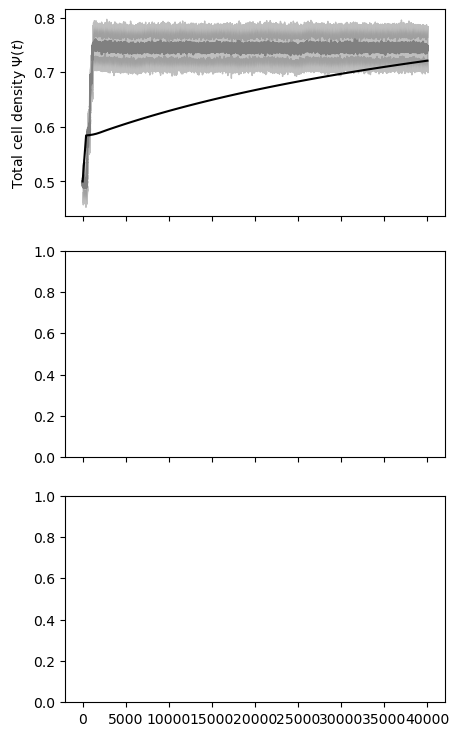

In [203]:
# wi = .6 * figwidth
# lw = 2
# set golden_ratio
golden_ratio = (np.sqrt(5) - 1.0) / 2.0
# get default figsize
wi, le = plt.rcParams['figure.figsize']
wi = 0.7 * wi
le = wi / golden_ratio

fig = plt.figure(constrained_layout=True, figsize=(wi, le))# , nrows=2, ncols=2, sharey=True, sharex=True, figsize=(wi, 0.9*wi/golden_ratio),
                        # gridspec_kw={'hspace': 0.1, 'wspace': 0.1}, tight_layout=True)
ax = fig.subplots(3, 1, sharey=False, sharex=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.05})

plt.sca(ax[0])
x = np.arange(tmax+1)
y =  lgca.dens_t.mean((1,2))/lgca.interaction_params['capacity']
yerr = lgca.dens_t.std((1,2), ddof=1)/lgca.interaction_params['capacity']  # /np.sqrt(lgca.dens_t.shape[1]*lgca.dens_t.shape[2])

# plt.plot(ts, rhoint, label='Integral MF')
# plt.plot(ts, rholoc, label='Local MF')
# plt.plot(ts, rhoana, label='Gaussian appr.')
# plt.plot(np.arange(len(lgca.dens_t)), lgca.dens_t.mean(-1).mean(-1)/lgca.interaction_params['capacity'], label='LGCA', alpha=.6)
# plt.plot(np.arange(len(lgca.dens_t)), lgca.dens_t.reshape(len(lgca.dens_t), -1)/lgca.interaction_params['capacity'], color='gray', label='_LGCA', alpha=.5)
# plot mean over space
plt.plot(x, y, color='gray', label='LGCA')
errors = plt.fill_between(x, y - yerr, y + yerr, alpha=.5, color='gray', antialiased=True, interpolate=True)
plt.plot(ts, rhoint_co, label='Integral corrected', c='k')
# plt.plot(np.arange(len(lgca.dens_t)), lgca.dens_t/lgca.interaction_params['capacity'], label='LGCA', alpha=.7)
# plt.ylim(.45, 1)
plt.ylabel('Total cell density $\\Psi (t)$')
# plt.legend()
# plt.xscale('log')

plt.sca(ax[1])
yerr = std_mean_prop_t
y = mean_prop_t  # .reshape(len(lgca.dens_t), -1)
yerr = std_mean_prop_t
# plt.plot(ts, meanalphaint_co, label='Nonlocal corrected')
# plt.plot(ts, meanalphaint, label='Nonlocal')
# plt.plot(ts, meanalphaloc, label='Local')
# plt.plot(ts, meanalphaana, label='Gaussian approx.')
# plt.plot(np.arange(len(lgca.dens_t)), lgca.dens_t.mean(-1).mean(-1)/lgca.interaction_params['capacity'], label='LGCA', alpha=.6)
# line = plt.plot(x, y, color='gray', label='_LGCA', alpha=.5, lw=.25)
errors = plt.fill_between(x, y - yerr, y + yerr, alpha=0.5, color='gray', antialiased=True, interpolate=True)
plt.plot(x, y, color='gray', label='LGCA')
plt.plot(ts, meanalphaint_co, label='Mean-field prediction', c='k')

# plt.plot(np.arange(len(lgca.dens_t)), lgca.dens_t/lgca.interaction_params['capacity'], label='LGCA', alpha=.7)
plt.title('')
# plt.xlim(50)
plt.ylim(0.1, 1)
plt.ylabel('Mean fitness $\\langle\\alpha\\rangle (t)$')
# plt.xlabel('$t$')
plt.legend()
# sns.despine()
# plt.xscale('log')
plt.sca(ax[-1])
# x = np.arange(tmax+1)
y = var_prop_t
x = np.arange(tmax+1)
# y = mean_prop_t
# errors = plt.fill_between(x, y - yerr, y + yerr, alpha=0.5, color='gray', antialiased=True, interpolate=True)
# plt.plot(ts, varint_co, label='Integral corrected')
# plt.plot(ts, varloc_co, label='Local corrected')
# plt.plot(ts, varint, label='Integral mean-field')
# plt.plot(ts, varloc, label='Local mean-field')
# plt.plot(ts, var_ana, label='Gaussian approx.')
# Applying np.sqrt to y-coordinates
varint_co_sqrt = np.sqrt(varint_co)
varloc_co_sqrt = np.sqrt(varloc_co)
# varint_sqrt = np.sqrt(varint)
# varloc_sqrt = np.sqrt(varloc)
var_ana_sqrt = np.sqrt(var_ana)

# Plotting
# plt.plot(ts, varint_co_sqrt, label='Integral corrected')
# plt.plot(ts, varint_sqrt, label='Integral mean-field')
# plt.plot(ts, varloc_sqrt, label='Local mean-field')
# plt.plot(ts, var_ana_sqrt, label='Gaussian approx.')
line = plt.plot(x, np.sqrt(y), color='gray', label='LGCA', alpha=1)
plt.plot(ts, varint_co_sqrt, label='Nonlocal corrected', c='k')
plt.title('')
plt.xlim(50, tmax)
# plt.ylim(0, 0.01)
plt.ylabel(r'SD of fitness $\sqrt{\langle\Delta\alpha^2\rangle} (t)$')
plt.xlabel('Time $t$')
plt.xscale('log')
# plt.loglog()
label_axes(fig)
# plt.savefig('moment_comparison_cancerdfe_36mixed.pdf', bbox_inches='tight', pad_inches=0)

[]

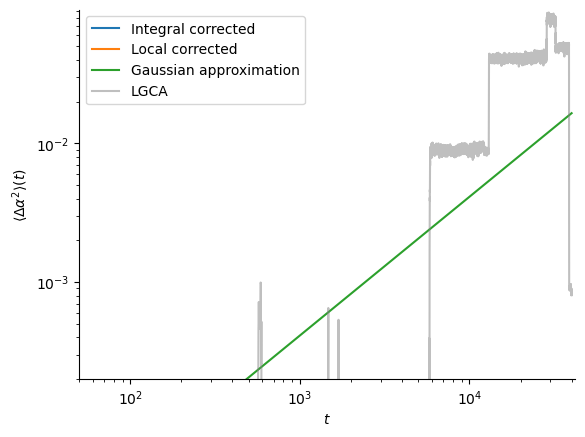

In [204]:
# yerr = std_mean_prop_t
x = np.arange(tmax+1)
y = var_prop_t
# errors = plt.fill_between(x, y - yerr, y + yerr, alpha=0.5, color='gray', antialiased=True, interpolate=True)
plt.plot(ts, varint_co, label='Integral corrected')
plt.plot(ts, varloc_co, label='Local corrected')
# plt.plot(ts, varint, label='Integral mean-field')
# plt.plot(ts, varloc, label='Local mean-field')
plt.plot(ts, var_ana, label='Gaussian approximation')
line = plt.plot(x, y, color='gray', label='LGCA', alpha=.5)

plt.title('')
plt.xlim(50)
plt.ylim(2e-4)
plt.ylabel('$\\langle\\Delta\\alpha^2\\rangle (t)$')
plt.xlabel('$t$')
plt.legend()
sns.despine()
# plt.xscale('log')
plt.loglog()

(0.0, 77.89456001189744)

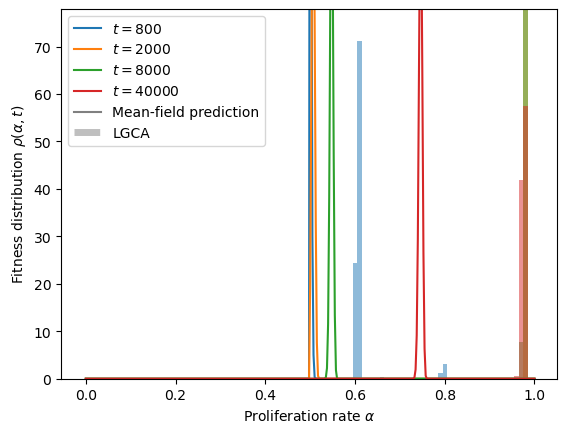

In [205]:
for t in [2, 5, 20, 100]:
    p = plt.plot(alpha, sol[t]/rhoint_co[t], label='$t = {:n}$'.format(ts[t]))
    p = plt.plot(alpha, sol2[t]/rholoc_co[t], label='$t = {:n}$'.format(ts[t]))
    # plt.plot(alpha, sol2[t]/rholoc_co[t], '--', label='t = {:n}'.format(ts[t]), color=p[0].get_color())
    # plt.plot(alpha, sol3[t]/rhoint[t], '-.', label='_t = {:n}'.format(ts[t]), color=p[0].get_color())
    # plt.plot(alpha, sol4[t]/rholoc[t], ':', label='_t = {:n}'.format(ts[t]), color=p[0].get_color())
    # plt.hist(lgca.get_prop(nodes=lgca.nodes_t[round(ts[t])]), bins='auto', density=True, color=p[0].get_color(), alpha=.5, edgecolor='none')
    plt.hist(lgca.get_prop(nodes=lgca.nodes_t[round(ts[t])]), bins=alpha[:-1:4], density=True, color=p[0].get_color(), alpha=.5, edgecolor='none', align='left')


#plt.plot(alpha, sol[-1], label='t = {:n}'.format(ts[-1]))
# p = plt.plot(alpha, sol[t], label='t = {:n}'.format(ts[t]))
# plt.plot(alpha, sol2[t], '--', label='_t = {:n}'.format(ts[t]), color=p[0].get_color())
plt.xlabel('Proliferation rate $\\alpha$')
plt.ylabel('Fitness distribution $\\rho(\\alpha, t)$')
leg = plt.legend()
lines, labels = plt.gca().get_legend_handles_labels()

# add new lines and labels
# lines += [plt.Line2D([0], [0], ls=ls, c='gray') for ls in ['-', '--', '-.', ':']]
# labels += ['Integral corrected', 'Local corrected', 'Integral', 'Local']

lines += [plt.Line2D([0], [0], ls=ls, c='gray') for ls in ['-']]
labels += ['Mean-field prediction']

# add legend entry for histogram with bar symbol
lines += [plt.Line2D([0], [0], ls='--', color='gray', lw=5, alpha=.5)]
labels += ['LGCA']

# create a new legend with all lines and labels
plt.legend(lines, labels)
plt.ylim(0, 1.1*np.max(sol[-1]))
# plt.savefig('density_comparison_cancerdfe_36mixed.pdf', bbox_inches='tight', pad_inches=0)

NameError: name 'sol4' is not defined

C:\Users\simon\anaconda3\envs\py311\Lib\site-packages\IPython\core\events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
C:\Users\simon\anaconda3\envs\py311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


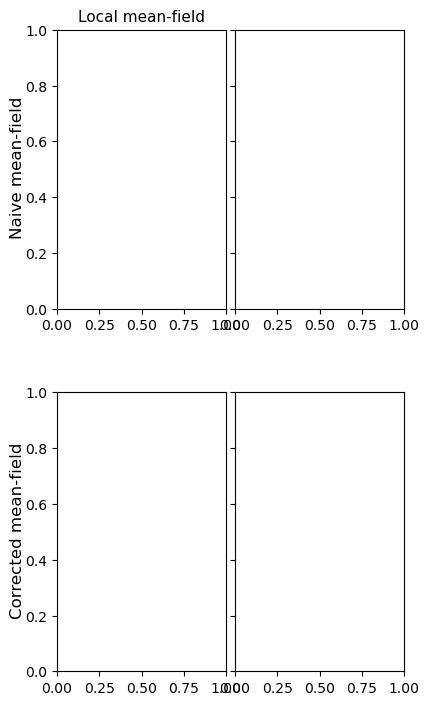

In [35]:
# wi = figwidth
lw = 2
fig = plt.figure(figsize=(wi, le), tight_layout=True)# , nrows=2, ncols=2, sharey=True, sharex=True, figsize=(wi, 0.9*wi/golden_ratio),
                        # gridspec_kw={'hspace': 0.1, 'wspace': 0.1}, tight_layout=True)
subfigs = fig.subfigures(2, 1)
axsup = subfigs[0].subplots(1, 2, sharey=True, sharex=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.05})
subfigs[0].supylabel('Naive mean-field')
axsdown = subfigs[1].subplots(1, 2, sharey=True, sharex=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.05})
subfigs[1].supylabel('Corrected mean-field')
fig.supylabel('Fitness distribution $\\rho(\\alpha, t)$')
fig.supxlabel('Fitness $\\alpha$')
# for t in np.linspace(1, len(ts)/1.5, 4, dtype=int, endpoint=False):
for t in (100, 300, 1000, 3000):
    t = (np.abs(ts - t)).argmin()
    # plt.sca(axsup[0])
    axsup[0].set_title('Local mean-field', fontsize=11)
    # axsup[0].set_ylabel('$\\rho(\\alpha, t)$')
    # .ylabel('No correction')
    p = axsup[0].plot(alpha, sol4[t] / rholoc[t], label='t = {:n}'.format(ts[t]))
    bins = round(np.ceil(np.log2(lgca.dens_t[round(ts[t])].sum()))+1) 
    axsup[0].hist(lgca.get_prop(nodes=lgca.nodes_t[round(ts[t])]), bins=bins, density=True, color=p[0].get_color(), alpha=.5)
    axsup[0].legend()
    axsup[0].set_xticklabels([])
    # plt.plot(alpha, sol2[t], '--', label='_t = {:n}'.format(ts[t]), color=p[0].get_color())
    # plt.sca(axsup[1])
    axsup[1].set_title('Integral mean-field', fontsize=11)
    axsup[0].set_ylim(0)
    axsup[0].set_xlim(0, 1)
   
    p = axsup[1].plot(alpha, sol3[t] / rhoint[t], label='_t = {:n}'.format(ts[t]))
    axsup[1].hist(lgca.get_prop(nodes=lgca.nodes_t[round(ts[t])]), bins=bins, density=True, color=p[0].get_color(), alpha=.5)

    
    # plt.plot(alpha, trunc_gaussian(alpha, meanalphaana[t], sqrt(var_ana[t]), a=0, b=1), '-.', color=p[0].get_color())
    
    # plt.sca(axsdown[0])
    # plt.ylabel('Low-density correction')
    # axsdown[0].set_xlabel('$\\alpha$')
    axsdown[0].hist(lgca.get_prop(nodes=lgca.nodes_t[round(ts[t])]), bins=bins, density=True, color=p[0].get_color(), alpha=.5)
    p = axsdown[0].plot(alpha, sol2[t] / rholoc_co[t], label='t = {:n}'.format(ts[t]))
    # axsdown[0].set_ylabel('$\\rho(\\alpha, t)$')

    # plt.plot(alpha, trunc_gaussian(alpha, meanalphaana[t], sqrt(var_ana[t]), a=0, b=1), '-.', color=p[0].get_color())
    
    # plt.sca(axsdown[1])
    axsdown[1].hist(lgca.get_prop(nodes=lgca.nodes_t[round(ts[t])]), bins=bins, density=True, color=p[0].get_color(), alpha=.5)
    p = axsdown[1].plot(alpha, sol[t] / rhoint_co[t], label='$t = {:n}$'.format(ts[t]))
    # axsdown[1].set_xlabel('$\\alpha$')
    # plt.plot(alpha, trunc_gaussian(alpha, meanalphaana[t], sqrt(var_ana[t]), a=0, b=1), '-.', color=p[0].get_color())

h = axsup[1].hist(lgca.get_prop(nodes=lgca.nodes_t[round(ts[-1])]), bins=bins, density=True, color='C0', visible=True, label='Cellular automaton', alpha=.5)
axsup[1].legend()
for rect in h[2].patches:
    rect.set_visible(False)
# fig.supxlabel('$\\alpha$')
# fig.supylabel('$\\rho(\\alpha)$')
plt.ylim(0)
plt.xlim(0, 1)
# sns.despine()
label_axes(fig)
# plt.savefig('mean-field_comparison.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# gamma distribution like in basener et al 2018
# var = 0.1**2
# mean = .5
# shape = 1.
# p_pos = 0.1
# # scale = (.5 - p_mut * shape) / mean
# scale = np.sqrt(.025)
# p_pos = .5 * (-.05/scale + 1)
# mean_mut_effect = -shape*scale * (1-p_pos) + p_pos * shape*scale
# # var = shape*scale**2
#
# mu = np.linspace(-(a_max-a_min), a_max-a_min, 2 * na - 1)
# basekernel = gamma_kernel(mu, shape, 0, scale, p_pos)
# # basekernel[len(basekernel)//2] = 0
# kernel = np.array([gamma_kernel(alpha, shape, a, scale, p_pos) for a in alpha])